In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow_probability as tfp
import warnings
import time
import gc
import torch
import torch.nn as nn
import lightgbm as lgb
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from torch.utils.data import Dataset, DataLoader, TensorDataset
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error

train_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
plt.rcParams.update({'font.size': 16})

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

2023-11-03 17:06:40.014220: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 17:06:40.032521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 17:06:40.032545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 17:06:40.032565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 17:06:40.036372: I tensorflow/core/platform/cpu_feature_g

GPU is not available, using CPU instead


# Utils

In [25]:
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
class CFG:
    BATCH_SIZE = 16
    N_EPOCHS = 500
    LEARNING_RATE = 0.0001
    N_FOLDS = 5
    TARGET_COLS = ['target']
    SEED = 2023
    N_ASSETS = train_df['stock_id'].nunique()
    N_TIMESTEPS = 1
    
CFG = CFG()
set_seeds(CFG.SEED)

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [27]:
train_df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

# EDA

In [28]:
train_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [29]:
def plot_hist(df):
    COLS = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id'], axis=1).columns)
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,40))
    for col, ax in zip(COLS, axes.ravel()):
        sns.lineplot(data=df, x='time_id', y=df[col], hue='stock_id', ax=ax)
        ax.legend(loc='best')
#plot_hist(train_df)

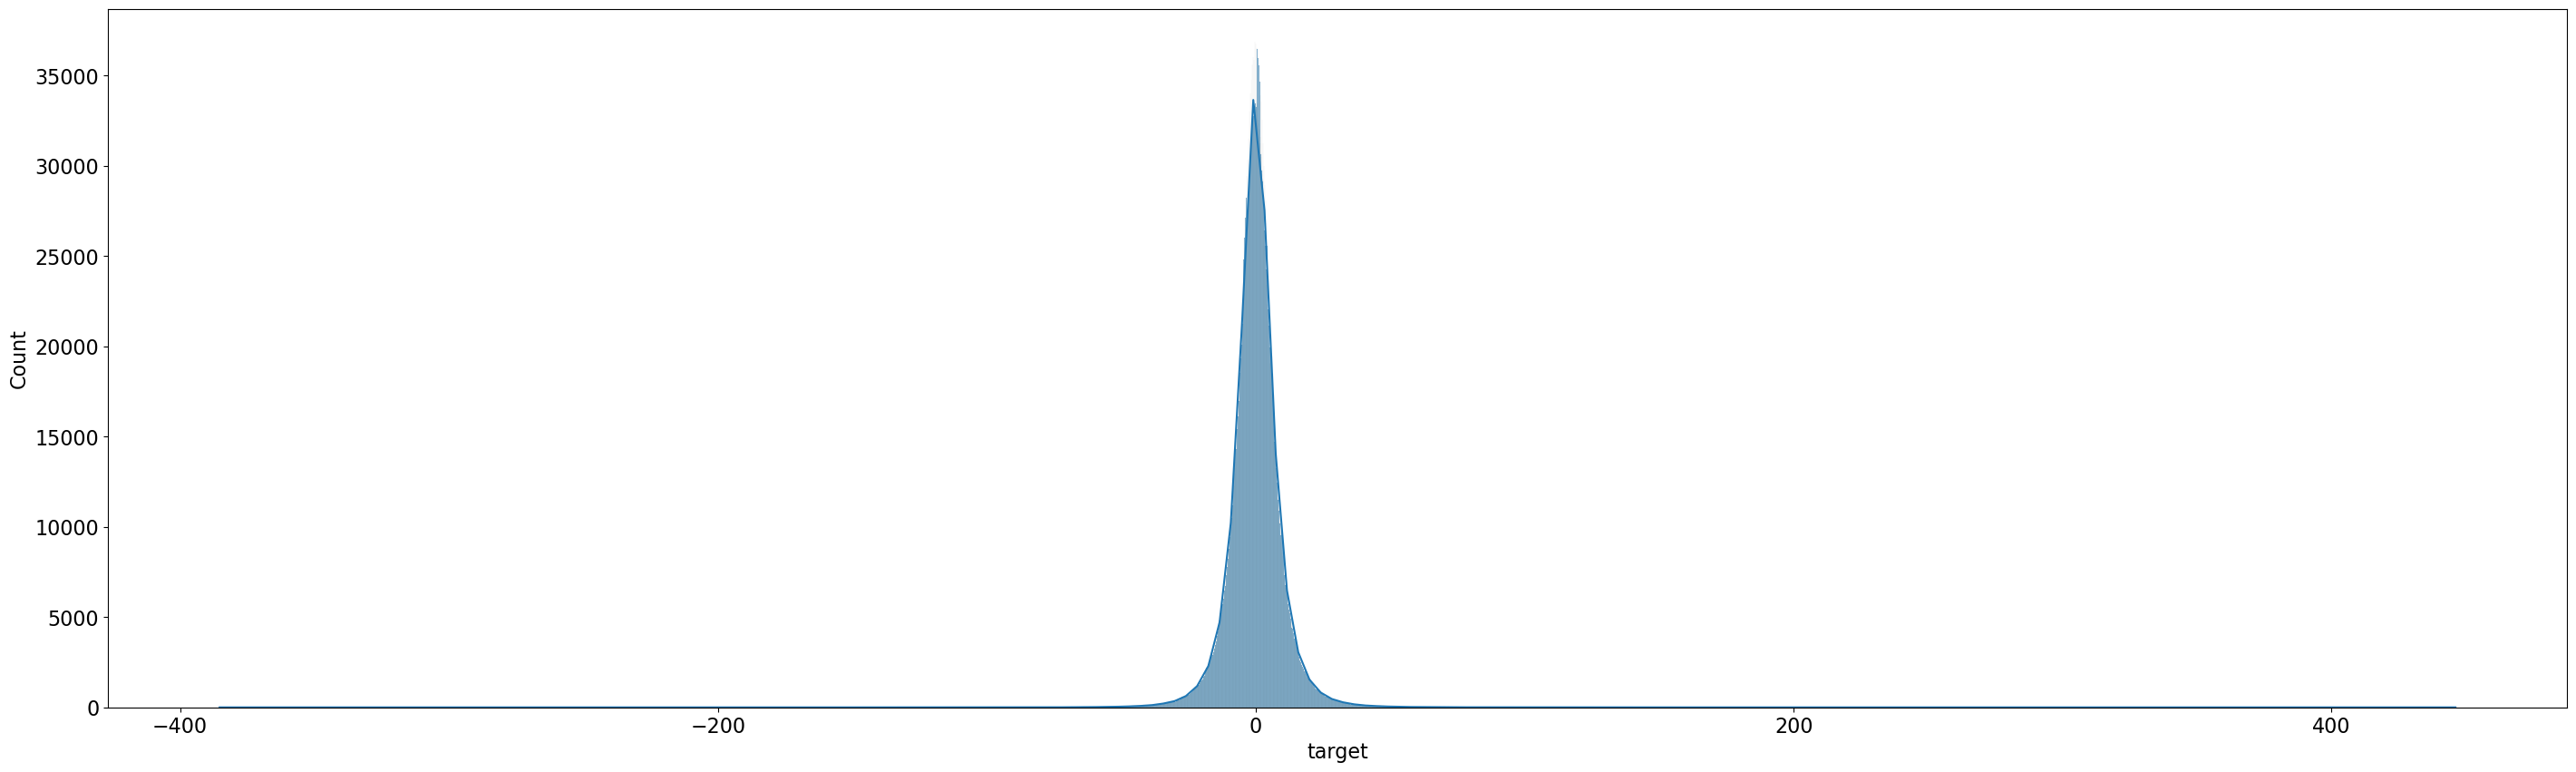

In [30]:
def plot_target(df):
    plt.figure(figsize=(35, 10))
    sns.histplot(data=df, x='target', kde=True) 
plot_target(train_df)

# PreProcessing

In [31]:
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [32]:
def preprocess(df):
    df['log_return'] = np.log(df['wap'])
    #df['reference_price_sma_15'] = df.groupby(['stock_id'])['reference_price'].rolling(15).mean()
    df.drop('imbalance_buy_sell_flag', axis=1, inplace=True)
    df.fillna(0, inplace=True)
    
preprocess(train_df)

# CV

In [33]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    stacking_mode : bool, default=True
        Whether to provide an additional set to test a stacking classifier or not. 
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    max_val_group_size : int, default=Inf
        Maximum group size for a single validation set.
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split, if stacking_mode = True and None 
        it defaults to max_val_group_size.
    val_group_gap : int, default=None
        Gap between train and validation
    test_group_gap : int, default=None
        Gap between validation and test, if stacking_mode = True and None 
        it defaults to val_group_gap.
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_val_group_size=np.inf,
                 max_test_group_size=np.inf,
                 val_group_gap=None,
                 test_group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.max_val_group_size = max_val_group_size
        self.max_test_group_size = max_test_group_size
        self.val_group_gap = val_group_gap
        self.test_group_gap = test_group_gap
        self.verbose = verbose
        
    def split(self, X, y=None, groups=None):
        return self.split_standard(X, y, groups)
        
    def split_standard(self, X, y=None, groups=None):
        """Generate indices to split data into training and validation set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/validation set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        val : ndarray
            The validation set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_splits = self.n_splits
        group_gap = self.val_group_gap
        max_val_group_size = self.max_val_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_val_size = min(n_groups // n_folds, max_val_group_size)
        group_val_starts = range(n_groups - n_splits * group_val_size,
                                  n_groups, group_val_size)
        for group_val_start in group_val_starts:
            train_array = []
            val_array = []

            group_st = max(0, group_val_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_val_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for val_group_idx in unique_groups[group_val_start:
                                                group_val_start +
                                                group_val_size]:
                val_array_tmp = group_dict[val_group_idx]
                val_array = np.sort(np.unique(
                                              np.concatenate((val_array,
                                                              val_array_tmp)),
                                     axis=None), axis=None)

            val_array  = val_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in val_array]

# Model

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1d1 = nn.Conv1d(200, 16, 2)
        self.conv1d2 = nn.Conv1d(16, 32, 2)
        
        self.pool1d1 = nn.AvgPool1d(2)
        self.pool1d2 = nn.AvgPool1d(2)
        
        self.batchnorm_1d1 = nn.BatchNorm1d(16)
        self.batchnorm_1d2 = nn.BatchNorm1d(32)

        self.lstm1 = nn.LSTM(64, 16, batch_first=True)
        self.lstm2 = nn.LSTM(16, 32, batch_first=True)
        self.lstm3 = nn.LSTM(32, 64, batch_first=True)

        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 200)
        
        self.flat = nn.Flatten()

    def forward(self, inputs):
        x = self.conv1d1(inputs)
        x = self.batchnorm_1d1(x)
        x = nn.ReLU()(x)
        x =  self.pool1d1(x)

        x = self.conv1d2(x)
        x = self.batchnorm_1d2(x)
        x = nn.ReLU()(x)
        x =  self.pool1d2(x)
        
        x = x.reshape(x.shape[0], 1, -1)
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
       
        out = self.flat(out)
        out = self.linear1(out)
        out = nn.ReLU()(out)
        
        output = self.linear2(out)
        
        return output

In [35]:
def pad_df(df):
    missing_ids = list(set(np.arange(0, 200)) - set(df.index))
    for id in missing_ids:
        df.loc[id] = 0
    df.sort_index(inplace=True)
    return df
    
def get_dataset(df):
    X = []
    y = []
    for name, group in df.groupby('time_id'):
        group = group.set_index('stock_id')
        if len(group) < 200:
            group = pad_df(group)  
        features = torch.tensor(group.drop(['date_id', 'row_id', 'far_price', 'near_price', 'target'], axis=1).values, dtype=torch.float32)
        features  = nn.functional.normalize(features, dim=0)
        labels = group['target'].values 
        X.append(features)
        y.append(labels)
    X_ = torch.stack(X)
    y_ = torch.tensor(np.array(y), dtype=torch.float32)
    return TensorDataset(X_, y_)       

In [36]:
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

In [37]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def get_score(y_val, y_pred):
    all_scores = []
    for i in range(len(y_val)):
        score = mean_absolute_error(y_val[i], y_pred[i])
        all_scores.append(score)
    return np.mean(all_scores)
        
def train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device):
    losses = AverageMeter()
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.update(loss.item(), labels.size(0))
        loss.backward()
        optimizer.step()
    return losses.avg

def valid_fn(valid_dataloader, model, loss_fn, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    for step, (input_ids, labels) in enumerate(valid_dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            outputs = model(input_ids)   
            loss = loss_fn(outputs, labels)
        losses.update(loss.item(), batch_size)
        preds.append(outputs.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def train_loop(train, val, fold):
    print(f'----------------- Fold: {fold+1} -----------------') 
    
    train_ds = get_dataset(train)
    val_ds = get_dataset(val)
    _, y_val = val_ds[:]
    
    train_dataloader = DataLoader(
            train_ds,  
            batch_size = CFG.BATCH_SIZE 
    )

    val_dataloader = DataLoader(
            val_ds,  
            batch_size = CFG.BATCH_SIZE
    )

    model = CNN().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
    loss_fn = RMSELoss()
    min_score = np.inf        
    wait = 0
    patience=10

    for epoch in range(CFG.N_EPOCHS):
        avg_loss = train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device)

        avg_val_loss, y_pred = valid_fn(val_dataloader, model, loss_fn, device)
   
        score = get_score(y_val, y_pred)

        print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} MAE: {score:.4f}')
           
        wait += 1
        if round(score, 4) < round(min_score, 4):
            min_score = score
            wait = 0
            torch.save(model.state_dict(), f'model_fold_{fold+1}')
            print(f'﹂ saving model with score: {min_score:.4f}')
        if wait >= patience:
            print(f'Triggering Early Stopping on epoch {epoch+1}')
            break
    gc.collect()

In [38]:
def train(df):
    Fold = PurgedGroupTimeSeriesSplit(n_splits=CFG.N_FOLDS,
                                      max_train_group_size=10000,
                                      max_val_group_size=200,
                                      val_group_gap=2)
    groups = df['time_id']
    for fold, (train_index, val_index) in enumerate(Fold.split(df, df[CFG.TARGET_COLS], groups=groups)):
        train = df.iloc[train_index].reset_index(drop=True)
        val = df.iloc[val_index].reset_index(drop=True)
        train_loop(train, val, fold)

train(train_df)

----------------- Fold: 1 -----------------
Epoch 1 - avg_train_loss: 6.3072 avg_val_loss: 5.5056 MAE: 5.5056
﹂ saving model with score: 5.5056
Epoch 2 - avg_train_loss: 6.3069 avg_val_loss: 5.5052 MAE: 5.5052
﹂ saving model with score: 5.5052
Epoch 3 - avg_train_loss: 6.3067 avg_val_loss: 5.5048 MAE: 5.5048
﹂ saving model with score: 5.5048
Epoch 4 - avg_train_loss: 6.3064 avg_val_loss: 5.5041 MAE: 5.5041
﹂ saving model with score: 5.5041
Epoch 5 - avg_train_loss: 6.3057 avg_val_loss: 5.5019 MAE: 5.5019
﹂ saving model with score: 5.5019
Epoch 6 - avg_train_loss: 6.3034 avg_val_loss: 5.4963 MAE: 5.4963
﹂ saving model with score: 5.4963
Epoch 7 - avg_train_loss: 6.2970 avg_val_loss: 5.4891 MAE: 5.4891
﹂ saving model with score: 5.4891
Epoch 8 - avg_train_loss: 6.2889 avg_val_loss: 5.4855 MAE: 5.4855
﹂ saving model with score: 5.4855
Epoch 9 - avg_train_loss: 6.2816 avg_val_loss: 5.4869 MAE: 5.4869
Epoch 10 - avg_train_loss: 6.2747 avg_val_loss: 5.4924 MAE: 5.4924
Epoch 11 - avg_train_lo

5.4983

In [39]:
def get_models():
    models = []
    for i in range(CFG.N_FOLDS):   
        model = CNN()
        model.load_state_dict(torch.load(f'/kaggle/working/model_fold_{i+1}'))
        model.eval()
        models.append(model)
    return models


In [40]:
def inference(models, y_test):
    preds = []
    for i in range(len(models)):
        pred = models[i](y_test)[0]
        preds.append(pred.detach().numpy())
    return np.mean(preds, axis=0)

In [18]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
history = pd.DataFrame()

models = get_models()

for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test): 
    preds = []
    history = pd.concat([history, test])
    history = history.reset_index(drop=True)
    preprocess(history)
    y_test = history.iloc[-len(test):, :]
    y_test = torch.tensor(y_test.drop(['date_id', 'row_id', 'far_price', 'near_price'], axis=1).values, dtype=torch.float32).unsqueeze(0)
    y_test  = nn.functional.normalize(y_test, dim=0)
    with torch.no_grad():
        preds = inference(models, y_test)
    sample_prediction['target'] = preds
    env.predict(sample_prediction)
    gc.collect()
        
gc.collect()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


0